# ML Project phase 2 - Sarcasm detection
# -----------------------------------------------


## EDA
**Understanding the structure of data set rows and columns, unique counts, missing values, dtypes, distributions, etc.**

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

!pip install contractions
import contractions
import re
import nltk
import tensorflow as tf
import gensim
from nltk.corpus import stopwords

     |████████████████████████████████| 286kB 5.9MB/s 
     |████████████████████████████████| 327kB 36.1MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85425 sha256=938083985b2ff7810ffa3a3a3b96eb6065521af9059a577591ba47b149254fd5
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp '../content/drive/MyDrive/Kaggle/projectPhase2_dataset.zip' '/content'
!unzip -q 'projectPhase2_dataset.zip'
# data = pd.read_csv('drive/MyDrive/drive/MyDrive/sarcasm_train_set.csv')
data = pd.read_csv('sarcasm_train_set.csv')

Mounted at /content/drive


**Which means many repeated comments.**

**The output of the below cell is a data frame consisting information about each column of the data set:**

In [ ]:
def get_df_columns_info(data: pd.DataFrame):
    col_names = list(data.dtypes.index)
    col_types = list(data.dtypes)
    col_numeric = ['Numeric' if (col_types[i] == 'int64' or col_types[i] == 'float64') 
                                       else 'Non-numeric' for i in range(len(col_types))]
    python_type = []
    for i in range(len(col_types)):
        if col_types[i] == 'int64':
            python_type.append('int')
        elif col_types[i] == 'float64':
            python_type.append('float')
        elif col_types[i] == 'bool':
            python_type.append('bool')
        elif col_types[i] == 'datetime64':
            python_type.append('datetime')
        else:
            python_type.append('str or mixed')
    
    null_percentage = list(round((data.isnull().sum() / len(data)) * 100, 2))

    empty_col = ['----' for _ in range(len(col_names))]
    mean, var, min, max, unique_value_count = empty_col.copy(), empty_col.copy(), empty_col.copy(),\
                                              empty_col.copy(), empty_col.copy()
    for i in range(len(col_names)):
        if col_numeric[i] == 'Non-numeric':
            unique_value_count[i] = len(data[col_names[i]].unique())
        else:
            min[i] = data.min()[col_names[i]]
            max[i] = data.max()[col_names[i]]
            mean[i] = round(data.mean()[col_names[i]], 2)
            var[i] = round(data.var()[col_names[i]], 2)

    columns_info = pd.DataFrame({
        'Column name': col_names,
        'Column Pandas-type': col_types,
        'Column Python-type': python_type,
        'Numeric/Non-numeric': col_numeric,
        '% of null values': null_percentage,
        'Unique values count': unique_value_count,
        'Min': min, 'Max': max, 'Mean': mean, 'Variance': var
    })
    return columns_info


# cols_info = get_df_columns_info(data.head(20000))
# cols_info

In [ ]:
data.comment.isna().sum()

38

* **Droping rows with missing comment:**

In [ ]:
data.dropna(subset=['comment'], inplace=True)

In [ ]:
data.isna().sum()

Unnamed: 0        0
label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

In [ ]:
data.label.value_counts()

1    404735
0    404225
Name: label, dtype: int64

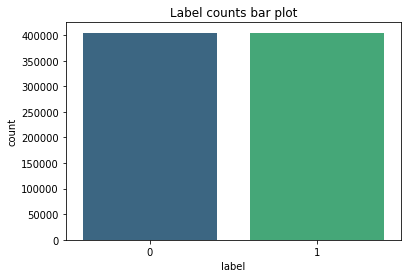

In [ ]:
sns.countplot(data.label, palette="viridis");
plt.title('Label counts bar plot');

**Dataset is balanced.**

* **Checking number of comments in most popular subredits:**

In [ ]:
freq = data.subreddit.value_counts().sort_values(ascending=False)
freq.head(20)

AskReddit          52716
politics           31662
worldnews          21201
leagueoflegends    16832
pcmasterrace       15233
funny              14292
news               13504
pics               12952
nfl                11336
todayilearned      11317
nba                11302
GlobalOffensive    10816
AdviceAnimals      10803
videos              9815
gaming              9577
The_Donald          7803
WTF                 7676
hockey              7008
soccer              6785
TumblrInAction      5995
Name: subreddit, dtype: int64

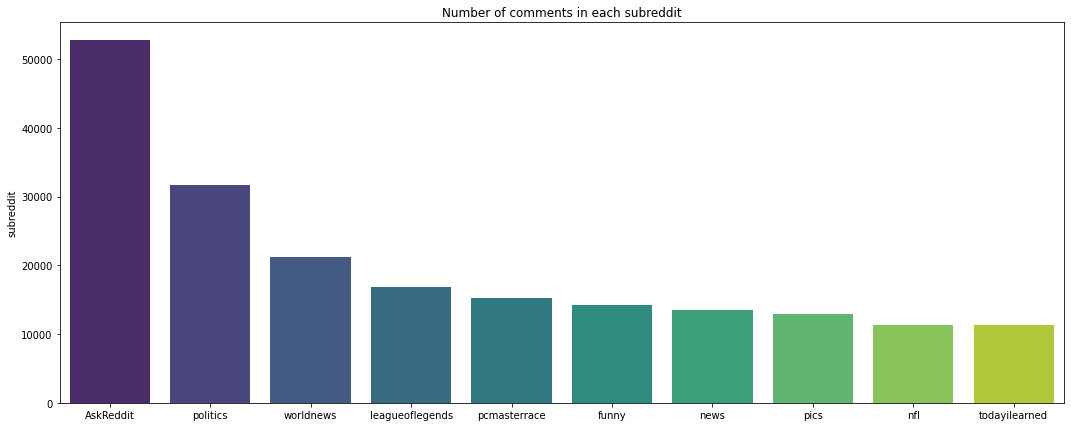

In [ ]:
freq = data.subreddit.value_counts().sort_values(ascending=False)
plt.figure(figsize=(18, 7))
sns.barplot(freq.head(10).index, freq.head(10), palette="viridis")
plt.title('Number of comments in each subreddit');

In [ ]:
sub = data[['label', 'subreddit']]
idx = np.zeros(len(sub))
for subr in freq.head(10).index:
    idx = idx | (sub.subreddit == subr)
sub = sub[idx]

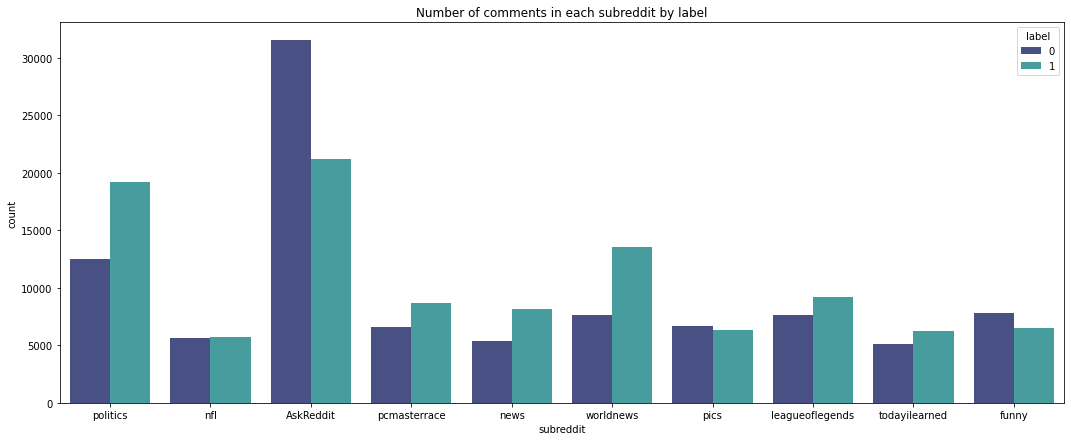

In [ ]:
plt.figure(figsize=(18, 7))
sns.countplot(sub.subreddit, hue=sub.label, palette="mako")
plt.title('Number of comments in each subreddit by label');

**Which subreddits have more sarcasm ratio?**

In [ ]:
ratio = data[['label', 'subreddit']].groupby('subreddit').agg([np.sum, np.mean, np.size])\
                            .sort_values(by=('label', 'size'), ascending=False)\
                            .head(10).sort_values(by=('label', 'mean'), ascending=False)[('label', 'mean')]
ratio

subreddit
worldnews          0.639923
politics           0.605521
news               0.600785
pcmasterrace       0.567584
todayilearned      0.550853
leagueoflegends    0.546162
nfl                0.504146
pics               0.486411
funny              0.453051
AskReddit          0.402307
Name: (label, mean), dtype: float64

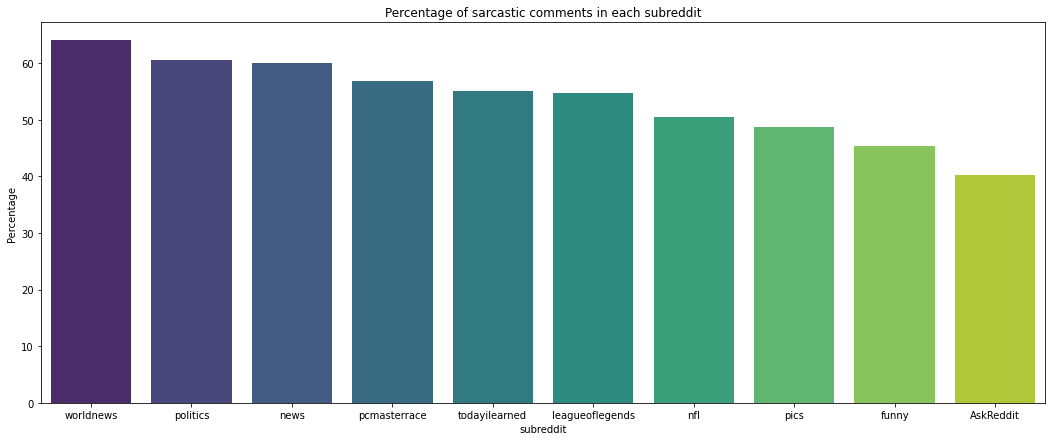

In [ ]:
plt.figure(figsize=(18, 7))
sns.barplot(ratio.index, ratio * 100, palette="viridis");
plt.title('Percentage of sarcastic comments in each subreddit');
plt.ylabel('Percentage');

* **Comments lengths and distributions:**

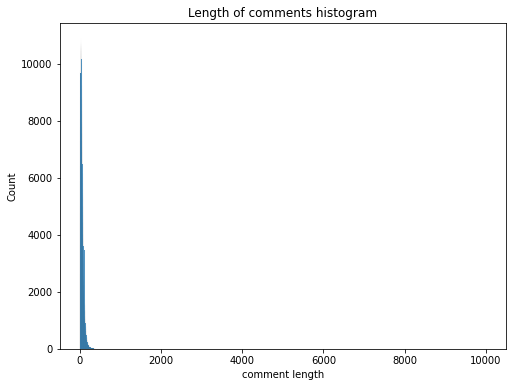

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(data.comment.str.len());
plt.title('Length of comments histogram');
plt.xlabel('comment length');

In [ ]:
data.comment.str.len().sort_values(ascending=False)

4493      10000
480954    10000
130521     9999
83427      9999
174232     9999
          ...  
710286        1
579872        1
579860        1
406675        1
88440         1
Name: comment, Length: 808960, dtype: int64

**There are some comments with length 10,000!**

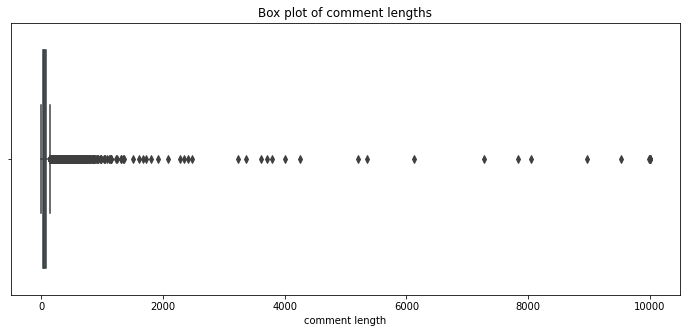

In [ ]:
plt.figure(figsize=(12, 5))
sns.boxplot(data.comment.str.len().sort_values(ascending=False));
plt.title('Box plot of comment lengths');
plt.xlabel('comment length');

In [ ]:
cl = data.comment.str.len()
len(cl[cl < 300])/len(data)

0.9978960640822785

**More than 99.7 % of comments are shorter than 300 characters. Lets see distribution of them:**

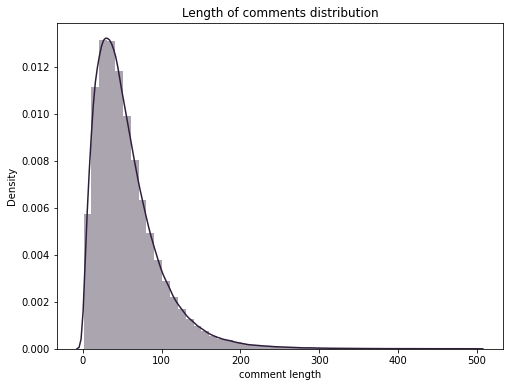

In [ ]:
plt.figure(figsize=(8, 6))
sns.set_palette("mako")
sns.distplot(cl[cl < 500]);
plt.xlabel('comment length');
plt.title('Length of comments distribution');

**Now, splitted by label:**

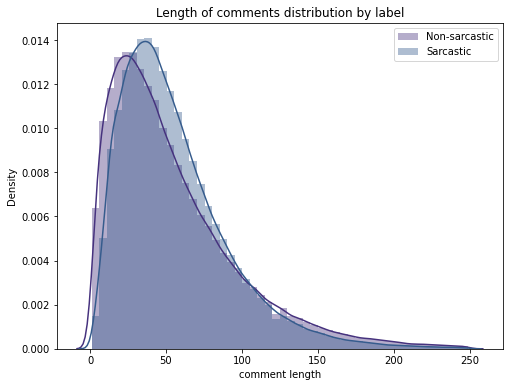

In [ ]:
plt.figure(figsize=(8, 6))
sns.set_palette("viridis")
sns.distplot(cl[(data.label == 0) & (cl < 250)], label='Non-sarcastic')
sns.distplot(cl[(data.label == 1) & (cl < 250)], label='Sarcastic')
plt.xlabel('comment length');
plt.title('Length of comments distribution by label');
plt.legend();

**Parent comments intersection with main comments:**

In [ ]:
len(set(data.comment).intersection(set(data.parent_comment)))

6149

* **Date and time distributions:**

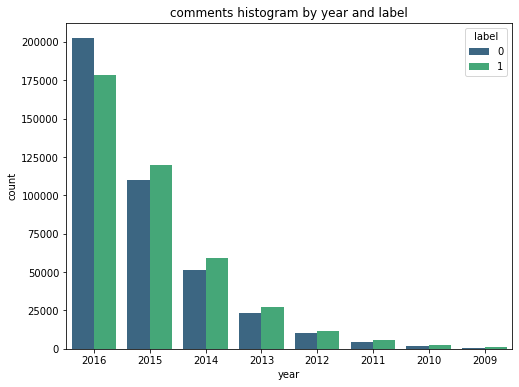

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data.date.str[:4], hue=data.label, palette="viridis")
plt.title('comments histogram by year and label');
plt.xlabel('year');

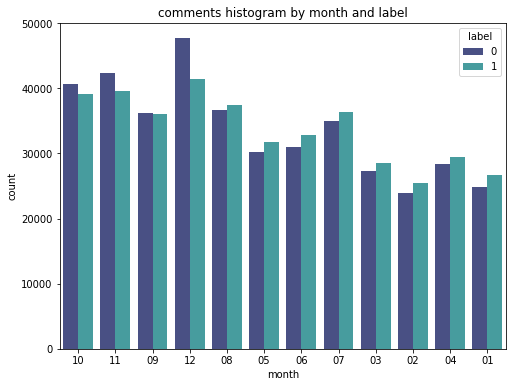

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data.date.str[5:], hue=data.label, palette="mako")
plt.title('comments histogram by month and label');
plt.xlabel('month');

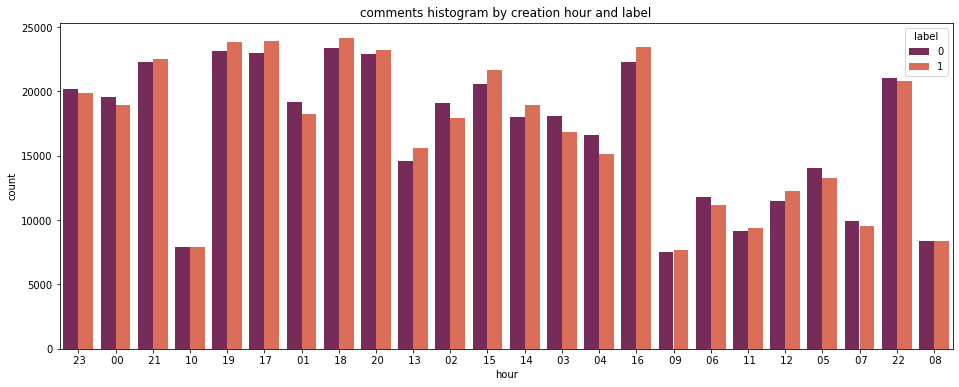

In [ ]:
plt.figure(figsize=(16, 6))
sns.countplot(data.created_utc.str[10:13], hue=data.label, palette="rocket")
plt.title('comments histogram by creation hour and label');
plt.xlabel('hour');

* **Scores, ups, and downs histograms by label:**


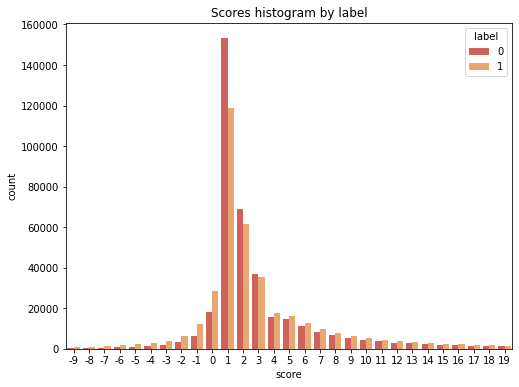

In [ ]:
s = data[['label', 'score']]
s = s[(s.score < 20) & (s.score > -10)]
sns.set_palette("Spectral")
plt.figure(figsize=(8, 6))
sns.countplot(s.score, hue=s.label);
plt.title('Scores histogram by label');
plt.xlabel('score');

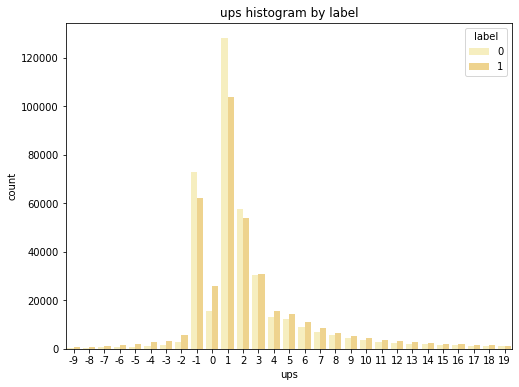

In [ ]:
s = data[['label', 'ups']]
s = s[(s.ups < 20) & (s.ups > -10)]
sns.set_palette("YlOrBr")
plt.figure(figsize=(8, 6))
sns.countplot(s.ups, hue=s.label);
plt.title('ups histogram by label');
plt.xlabel('ups');

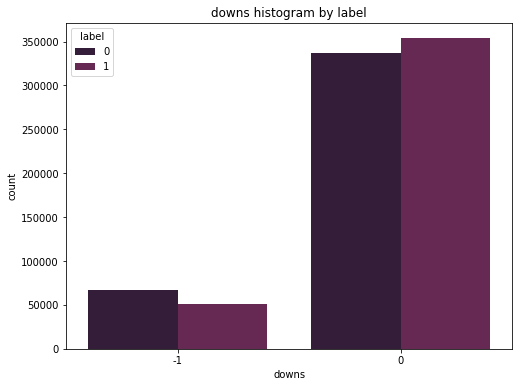

In [ ]:
s = data[['label', 'downs']]
s = s[(s.downs < 20) & (s.downs > -10)]
sns.set_palette("rocket")
plt.figure(figsize=(8, 6))
sns.countplot(s.downs, hue=s.label);
plt.title('downs histogram by label');
plt.xlabel('downs');

**Word cloud:**

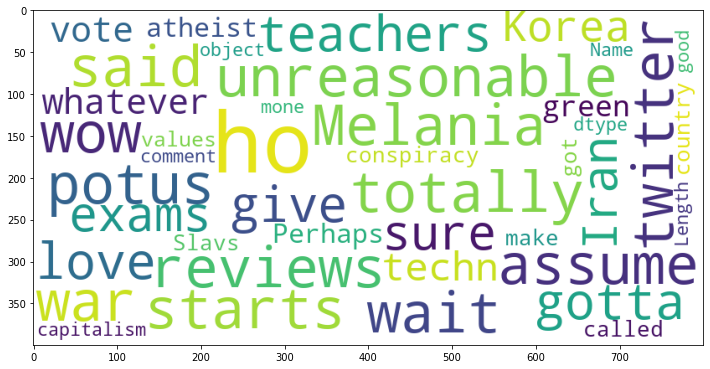

In [ ]:
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS,
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=400)

plt.figure(figsize=(12, 12))
wordcloud.generate(str(data.loc[data['label'] == 1, 'comment']))
plt.grid(b= False)
plt.imshow(wordcloud);

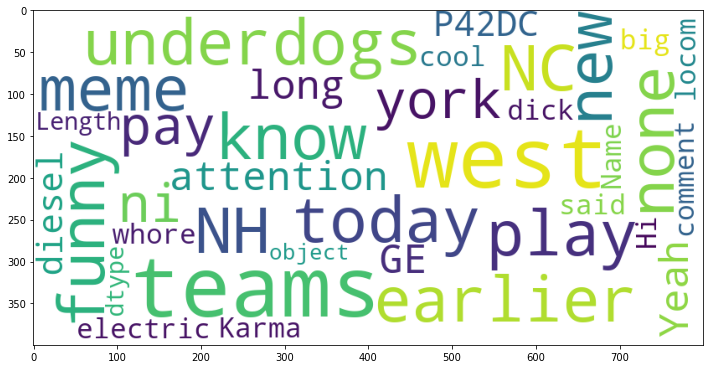

In [ ]:
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS,
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=400)

plt.figure(figsize=(12, 12))
wordcloud.generate(str(data.loc[data['label'] == 0, 'comment']))
plt.grid(b= False)
plt.imshow(wordcloud);

* **Checking comments number of special characters:**

In [ ]:
import re
just_spec = data.comment.apply(lambda x: re.sub('[a-zA-Z0-9]+', '', x))
just_spec = just_spec.apply(lambda x: re.sub(' ', '', x))
just_spec

0              .
1              ?
2           ,',-
3           '"".
4         ',''()
           ...  
808993     './/.
808994       ,'!
808995         ?
808996         -
808997     ,....
Name: comment, Length: 808960, dtype: object

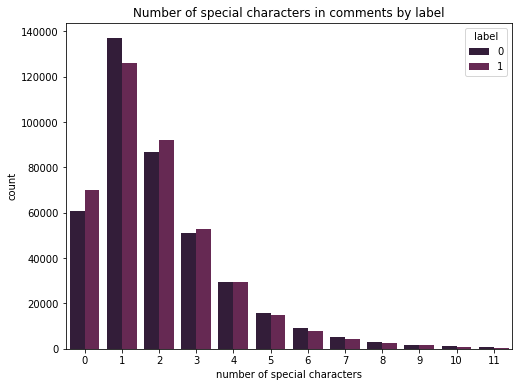

In [ ]:
sns.set_palette("rocket")
plt.figure(figsize=(8, 6))
sns.countplot(just_spec.str.len()[just_spec.str.len() < 12], hue=data.label[just_spec.str.len() < 12]);
plt.title('Number of special characters in comments by label');
plt.xlabel('number of special characters');

## Preprocessing
Here we're going to make some changes in texts to make them more digestible (for example removing non ascii characters if there are any).

First let's check to see if there are any non ascii characters

In [ ]:
data['comment'].apply(lambda x : x.isascii()).all()

True

Looks like there aren't any!

Now we implemente  function to preprocess data.

In [ ]:
def preprocess(data):
    #Now let's expand contractions, for example changing "don't" to "do not".
    pre_data = data.apply(lambda x : contractions.fix(x))

    #Now we will remove special characters like dots, question marks, etc.
    pre_data = pre_data.apply(lambda x: re.sub('[^a-zA-Z0-9]+', ' ', x))

    #We are going to convert words to their base form (Lemmatization). for example convert "caring" to "care".
    nltk.download('wordnet')
    lemmatizer = nltk.stem.WordNetLemmatizer()

    for pos_tag in ['v', 'n', 'a']: # v for verbs, n for nouns and a for adverbs
        pre_data = pre_data.apply(lambda text: ' '.join([lemmatizer.lemmatize(w, pos_tag) for w in text.split()]) )

    #Now let's remove stopwords because they don't contain much  information and removing them will make our data smaller. (we have to test later)
    nltk.download('stopwords')

    stop_words = set(stopwords.words('english'))
    pre_data = pre_data.apply(lambda text: ' '.join(word for word in text.split() if not word.lower() in stop_words))
    return pre_data

In [ ]:
def replace_zero_length(pre_data):
    k = [False if len(x)!=0 else True for x in pre_data]
    print(sum(k))
    for i,x in enumerate(k):
        if x==True :
            pre_data[i] = []
        return pre_data


raw_data = data['comment']
# pre_data = replace_zero_length(preprocess(data['comment']))

# pre_sentences = [[word for word in document.lower().split()] for document in pre_data]
raw_sentences = [[word for word in document.lower().split()] for document in raw_data]

## Embedding 


* **At first we use Word2Vec model**

In [ ]:
# pre_embed = gensim.models.Word2Vec(pre_sentences, size=100, window=5, min_count=1)
raw_embed = gensim.models.Word2Vec(raw_sentences, size=100, window=5, min_count=1)

In [ ]:
def get_word2vec_enc(comments, embed):
    """
    get word2vec value for each word in sentence.
    concatenate words in numpy array, so we can use it as RNN input
    """
    encoded_comments = []
    for comment in comments:
        word2vec_embedding = embed.wv[comment]
        encoded_comments.append(word2vec_embedding)
    return encoded_comments
        
    
def word2vec_padding(df, embed):
    """
    encode text value to numeric value
    """
    # encode words into word2vec    
    encoded_comment = get_word2vec_enc(df,embed)
    padded_encoded_comments = tf.keras.preprocessing.sequence.pad_sequences(encoded_comment, maxlen=100, dtype="float64")
    # encoded sentiment
    X = np.array(padded_encoded_comments)
    return X

import gc
def w2v_mean(comments, embed):
    encoded_comments = []
    for i, comment in enumerate(comments):
        if i % 5000 == 0:
            gc.collect()
        word2vec_embedding = embed.wv[comment]
        encoded_comments.append(word2vec_embedding.mean(axis=0))
    return encoded_comments


In [ ]:
# w2v_pre_x = word2vec_padding(pre_sentences[0:10000], pre_embed)
# w2v_raw_x = word2vec_padding(raw_sentences[0:15000], raw_embed)
# w2v_mean_raw = w2v_mean(raw_sentences, raw_embed)

In [ ]:
# w2v_mean_raw = np.vstack(w2v_mean_raw)

* **Tokenizing:**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 1000
embedding_dim = 100
max_length = 100 
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

def token_seq(data):
    tokenize = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
    tokenize.fit_on_texts(data)
    word_index = tokenize.word_index

    data_seq = tokenize.texts_to_sequences(data)

    data_padded = pad_sequences(data_seq, truncating=trunc_type, padding=padding_type, maxlen=max_length)
    return data_padded


unem_pre_x = token_seq(pre_data)
unem_raw_x = token_seq(raw_data)

* **TF-IDF:**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
 
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=100000, min_df=2)
raw_x_itf = vectorizer.fit_transform(raw_data)

# vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=100000, min_df=2)
# pre_x_itf = vectorizer.fit_transform(pre_data)




# Models

## Logistic Regression

### Using grid search for tuning hyperparameters:
**Logistic Regression with tf-idf**


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as met
from sklearn.model_selection import GridSearchCV

# This is a function to perform logistic regression several times with pre-defined hyperparameters or default ones.
def log_reg(data, y, t_size, penalty, r, train_repeat, split_random, clf_random, clf_param):
    res = pd.DataFrame()
    if split_random != 'rand':
        sp_rs = split_random
    if clf_random != 'rand':
        clf_rs = clf_random   
    for train in range(train_repeat):
        if split_random == 'rand':
            sp_rs = np.random.randint(100)
        if clf_random == 'rand':
            clf_rs = np.random.randint(100)  
        X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=t_size, shuffle=True,\
                                                            random_state=sp_rs)
        lg_clf = LogisticRegression()
        if clf_param is not None:
            penalty, max_iter, tol, C = clf_param
            lg_clf = LogisticRegression(random_state=clf_rs, penalty=penalty, max_iter=max_iter,\
                                                                                        tol=tol, C=C, n_jobs=-1)
        else:
            lg_clf = LogisticRegression(random_state=clf_rs, max_iter=400, penalty=penalty, C=r,\
                                                             solver='liblinear', n_jobs=-1)
        lg_clf = lg_clf.fit(X_train, y_train)
        pred = lg_clf.predict(X_test)
        acc, f1, prec, rec, roc = score(y_test, pred)
        res['Train: ' + str(train)] = [acc, f1, prec, rec, roc]
    res.index = ['Accuracy', 'F1_score', 'Precision', 'Recall', 'ROC_AUC']
    res['Mean'] = res.mean(axis=1)
    res['Std'] = res.std(axis=1)
    return res


def score(y_test, pred):
    if y_test.sum() == len(y_test) or y_test.sum() == 0: 
        return met.accuracy_score(y_test, pred), met.f1_score(y_test, pred),\
        met.precision_score(y_test, pred),\
        met.recall_score(y_test, pred), None
    return met.accuracy_score(y_test, pred), met.f1_score(y_test, pred),\
    met.precision_score(y_test, pred),\
    met.recall_score(y_test, pred),\
    met.roc_auc_score(y_test, pred)

In [ ]:
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(raw_x_itf, y, test_size=0.2, shuffle=True, random_state=0)
param_grid = {
    'penalty': ['l1', 'l2'],
    'max_iter': [500, 1000, 10000],
    'tol': [1e-4, 1e-6],
    'C': [0.05, 0.5, 1, 1.5]
}

lg_clf = LogisticRegression()
grid_s = GridSearchCV(estimator = lg_clf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2, scoring='f1')
grid_s.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 33.8min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 61.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.05, 0.5, 1, 1.5],
                         'max_iter': [500, 1000, 10000],
                         'penalty': ['l1', 'l2'], 'tol': [0.0001, 1e-06]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=2)

In [ ]:
grid_s.best_params_

{'C': 1, 'max_iter': 500, 'penalty': 'l2', 'tol': 0.0001}

**Using best hyperparameters that grid search have found the best ones:**

In [ ]:
params = (grid_s.best_params_['penalty'], grid_s.best_params_['max_iter'],\
                           grid_s.best_params_['tol'], grid_s.best_params_['C'])

log_reg(raw_x_itf, y, 0.2, penalty=None, r=None, train_repeat=3, split_random='rand', clf_random='rand', clf_param=params)

,Train: 0,Train: 1,Train: 2,Mean,Std
Accuracy,0.722267,0.720468,0.723046,0.721927,0.001079
F1_score,0.711787,0.709788,0.712259,0.711278,0.001071
Precision,0.738173,0.738487,0.739197,0.738619,0.000428
Recall,0.687222,0.683237,0.687216,0.685892,0.001877
ROC_AUC,0.722200,0.720492,0.722959,0.721884,0.001032


In [ ]:
# from sklearn.pipeline import Pipeline
# y = data['label']
# X_train, X_test, y_train, y_test = train_test_split(raw_data, y, test_size=0.2, shuffle=True, random_state=43)
# lg_clf = LogisticRegression(C=1, max_iter=500, penalty='l2', tol=1e-4,  n_jobs=-1)
# lg_pipeline = Pipeline([('vectorizer', vectorizer), ('lg_clf', lg_clf)])
# lg_pipeline.fit(X_train, y_train)

# !pip install eli5
import eli5
weights = eli5.show_weights(estimator = lg_pipeline.named_steps['lg_clf'], vec = lg_pipeline.named_steps['vectorizer'], top=150)

In [ ]:
weights

Weight?,Feature
+9.093,yes because
+7.595,obviously
+7.540,clearly
+7.301,totally
+6.844,because
+6.739,yeah because
+5.728,how dare
+5.635,good thing
+5.161,gee
+5.105,duh


## Random Forest

**Using tf-idf dataset:**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# This is a function to train a random forest classifier several times with
# pre-defined hyperparameters or default ones.
def ran_for(data, y, t_size, max_d, crit, train_repeat, split_random, clf_random, clf_param):
    res = pd.DataFrame()
    if split_random != 'rand':
        sp_rs = split_random
    if clf_random != 'rand':
        clf_rs = clf_random   
    for train in range(train_repeat):
        if split_random == 'rand':
            sp_rs = np.random.randint(100)
        if clf_random == 'rand':
            clf_rs = np.random.randint(100)  
        X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=t_size, shuffle=True,\
                                                            random_state=sp_rs)
        rf_clf = RandomForestClassifier()
        if clf_param is not None:
            # Unpacking model parameters from arguments:
            criterion, max_depth, max_features, max_samples, n_estimators = clf_param
            rf_clf = RandomForestClassifier(random_state=clf_rs, criterion=criterion, max_depth=max_depth,\
                     n_estimators=n_estimators, max_samples=max_samples, max_features=max_features, n_jobs=-1)
        else:
            # Using default model parameters:
            rf_clf = RandomForestClassifier(bootstrap=True, random_state=clf_rs, max_features='auto', max_samples=None,\
                                       n_estimators=200, max_depth=max_d, criterion=crit, n_jobs=-1)
        rf_clf = rf_clf.fit(X_train, y_train)
        pred = rf_clf.predict(X_test)
        acc, f1, prec, rec, roc = score(y_test, pred)
        res['Train #' + str(train+1)] = [acc, f1, prec, rec, roc]
    res.index = ['Accuracy', 'F1_score', 'Precision', 'Recall', 'ROC_AUC']
    res['Mean'] = res.mean(axis=1)
    res['Std'] = res.std(axis=1)
    return res


def print_score(y_test, pred):
    print('Accuracy:  ', met.accuracy_score(y_test, pred))
    print('F1_score:  ', met.f1_score(y_test, pred))
    print('Precision: ', met.precision_score(y_test, pred))
    print('Recall:    ', met.recall_score(y_test, pred))

In [ ]:
params = ('gini', 600, 'auto', None, 2)
ran_for(raw_x_itf, y, 0.2, None, None, train_repeat=1, split_random='rand', clf_random='rand', clf_param=params)

,Train #1,Mean,Std
Accuracy,0.624308,0.624308,0.0
F1_score,0.550693,0.550693,0.0
Precision,0.691300,0.691300,0.0
Recall,0.457617,0.457617,0.0
ROC_AUC,0.625353,0.625353,0.0


**Trying with w2v:**

In [ ]:
w2v_raw__for_random_forest = []
for mat in w2v_raw_x:
    vec = mat.reshape(1, w2v_raw_x.shape[1] * w2v_raw_x.shape[2])
    w2v_raw__for_random_forest.append(vec)
w2v_raw__for_random_forest = np.vstack(w2v_raw__for_random_forest)

In [ ]:
y = pd.Series(list(y))
params = ('gini', 500, 'auto', None, 2)
ran_for(w2v_raw__for_random_forest, y[:15000], 0.2, None, None, train_repeat=1, split_random='rand', clf_random='rand', clf_param=params)

,Train #1,Mean,Std
Accuracy,0.622000,0.622000,0.0
F1_score,0.254928,0.254928,0.0
Precision,0.415418,0.415418,0.0
Recall,0.183886,0.183886,0.0
ROC_AUC,0.521763,0.521763,0.0


* **Logistic Regression with w2v:**

**SVM with tf-idf data:**

In [ ]:
import gc
gc.collect()
from sklearn.svm import LinearSVC
param_grid = {
    'penalty': ['l1', 'l2'],
    'max_iter': [1000, 10000],
    'tol': [1e-4, 1e-6, 1e-8],
    'C': [0.0005, 0.05, 1, 5]
}
X_train, X_test, y_train, y_test = train_test_split(raw_x_itf, y, test_size=0.2, shuffle=True, random_state=73)
svm_clf = LinearSVC()
grid_s = GridSearchCV(estimator = svm_clf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2, scoring='f1')
grid_s.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 23.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0005, 0.05, 1, 5], 'max_iter': [1000, 10000],
                         'penalty': ['l1', 'l2'],
                         'tol': [0.0001, 1e-06, 1e-08]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=2)

In [ ]:
grid_s.best_params_

{'C': 0.05, 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.0001}

In [ ]:
svm_clf = LinearSVC(C=0.05, max_iter=1000, penalty='l2', tol=1e-4)
svm_clf.fit(X_train, y_train)
pred = svm_clf.predict(X_test)
print_score(pred, y_test)

Accuracy:   0.7209936214398734
F1_score:   0.707292875715703
Precision:  0.67353718477536
Recall:     0.7446105536214076


In [ ]:
param_grid = {
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
}
X_train, X_test, y_train, y_test = train_test_split(raw_x_itf, y, test_size=0.2, shuffle=True, random_state=73)
svm_clf = LinearSVC()
grid_s = GridSearchCV(estimator = svm_clf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2, scoring='f1')
grid_s.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=2)

In [ ]:
grid_s.best_params_

{'C': 0.1}

In [ ]:
svm_clf = LinearSVC(C=0.1, max_iter=1000, penalty='l2', tol=1e-4)
svm_clf.fit(X_train, y_train)
pred = svm_clf.predict(X_test)
print_score(pred, y_test)

Accuracy:   0.7217044106012658
F1_score:   0.7099027124540945
Precision:  0.680366537407069
Recall:     0.7421197262783555


**SVM with w2v mean vectors (all data):**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(w2v_mean_raw, y, test_size=0.2, shuffle=True, random_state=73)
svm_clf = LinearSVC(C=0.1, max_iter=1000, penalty='l2', tol=1e-4)
svm_clf.fit(X_train, y_train)
pred = svm_clf.predict(X_test)
print_score(pred, y_test)

Accuracy:   0.6441356803797469
F1_score:   0.6326280595186442
Precision:  0.6122212068071232
Recall:     0.6544422442244224


In [ ]:
# X = np.vstack([mat.reshape(100 * 100) for mat in w2v_raw_x])
# x_train, x_val, y_train, y_val = train_test_split(X, y[:10000], test_size=0.2, random_state=12)
clf = LogisticRegression()
# clf.fit(x_train, y_train)
# pred = clf.predict(x_val)
# print('Accuracy score: ', met.accuracy_score(pred, y_val))
# print('F1 score:       ', met.f1_score(pred, y_val))

Accuracy score:  0.7208514636075949
F1 score:        0.7094628497909296


In [ ]:
import gensim
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential
from keras.layers import Dense, Activation

y = data['label']

from sklearn.model_selection import train_test_split
raw_x_w2v_train, raw_x_w2v_val, raw_y_w2v_train, raw_y_w2v_val = train_test_split(w2v_raw_x, y[0:10000], test_size=0.2, random_state=12)
pre_x_w2v_train, pre_x_w2v_val, pre_y_w2v_train, pre_y_w2v_val = train_test_split(w2v_pre_x, y[0:10000], test_size=0.2, random_state=42)


raw_x_unem_train, raw_x_unem_val, raw_y_unem_train, raw_y_unem_val = train_test_split(unem_raw_x, y, test_size=0.2, random_state=42)
pre_x_unem_train, pre_x_unem_val, pre_y_unem_train, pre_y_unem_val = train_test_split(unem_pre_x, y, test_size=0.2, random_state=42)


raw_x_itf_train, raw_x_itf_val, raw_y_itf_train, raw_y_itf_val = train_test_split(raw_x_itf, y, test_size=0.2, random_state=42)
pre_x_itf_train, pre_x_itf_val, pre_y_itf_train, pre_y_itf_val = train_test_split(pre_x_itf ,y, test_size=0.2, random_state=42)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
def LSTM_without_embed(x_train,y_train,x_test,y_test):
  with tf.device('/device:GPU:0'):
    model = tf.keras.Sequential([
          tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(64, return_sequences = True)),
          tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(32)),
          tf.keras.layers.Dense(1, activation='sigmoid')])
    opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=0.02)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=64,verbose=2)



In [ ]:
LSTM_without_embed(raw_x_w2v_train,raw_y_w2v_train, raw_x_w2v_val, raw_y_w2v_val)

In [ ]:
LSTM_without_embed(pre_x_w2v_train,pre_y_w2v_train, pre_x_w2v_val, pre_y_w2v_val)

# -----------------------------------------------------------------

* **Custom deep neural network:**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from matplotlib import pyplot as plt
import sys
!pip install colorama
import colorama
from collections import OrderedDict
from matplotlib import pyplot as plt 
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
torch.set_printoptions(precision=3)
import os
import sklearn.metrics as met


In [ ]:
y=data['label']
dset = []
for i, mat in enumerate(w2v_raw_x):
    t = torch.from_numpy(mat)
    dset.append((t, y[i]))

In [ ]:
len(dset)

10000

In [ ]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, data_list):
        np.random.shuffle(data_list)
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        d = self.data_list[idx]
        return d[0], d[1]


train_data = CustomDataset(dset)

In [ ]:
from torch.utils.data import DataLoader

def sampler(dataset):
    return SubsetRandomSampler(np.random.choice(np.array(list(range(len(dataset)))),\
                                                    size=len(dataset), replace=False))

def loader(dataset, sampler=None):
    samp = None
    if sampler is not None:
        samp = sampler
    else:
        samp = sampler(dataset)
    return DataLoader(dataset, 
                      batch_size = batch_size,
                      sampler = samp,
                      num_workers = num_workers)


val_size = 0.15
num_workers = 4
batch_size = 128

# creating train and validation data samples:
num = len(train_data)
sp = int(val_size * num)
ind = list(range(num))
np.random.shuffle(ind)
val_ind, train_ind = ind[:sp], ind[sp:]
train_samp, val_samp = SubsetRandomSampler(train_ind), SubsetRandomSampler(val_ind)

# creating data loaders:
train_loader = loader(train_data, train_samp)
val_loader = loader(train_data, val_samp)

In [ ]:
next(iter(train_loader))[0].shape

torch.Size([128, 100, 100])

In [ ]:
class N_net(nn.Module):
    def __init__(self, input_matrix_dim=50):
        super(N_net, self).__init__()
        self.fc1 = nn.Linear(in_features=10000, out_features=10000)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.bnorm = nn.BatchNorm1d(num_features=10000)
        self.fc2 = nn.Linear(in_features=10000, out_features=2)
        nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        out = x.view(x.shape[0], -1)
        out = self.fc1(out)
        # out = self.bnorm(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.softmax(out)
        return out

In [ ]:
nn_model = N_net()

In [ ]:
test_input = torch.randn(128, 100, 100) 
out = nn_model(test_input)
print("out.shape: \n%s" % (out.shape,))

out.shape: 
torch.Size([128, 2])


In [ ]:
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
test_acc_all, train_acc_all, val_acc_all, train_loss_all = [], [], [], []
acc_all, f1_all, prec_all, rec_all = [], [], [], []

def train_cnn(model, train_loader, test_loader, val_loader, device, num_epochs, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCELoss()
    scheduler = ExponentialLR(optimizer, gamma=0.9)
    blocks, best_acc = 0, 0
    for epoch in range(num_epochs):
        print("=" * 25, "Starting epoch %d" % (epoch + 1), "=" * 25)
        names = ['train_loader']
        for d_idx, dataloader in enumerate([train_loader]):
            for batch_idx, (data, labels) in enumerate(dataloader):
                model.train()
                data, labels = data.to(device), labels.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output[:, 1].to(torch.float64), labels.to(torch.float64))
                loss.backward()
                optimizer.step()
                if batch_idx % 15 == 0:
                    print("\nstarting batch %d/%d, Loss=%.4f" % (batch_idx, len(dataloader), loss.item()), end=' ')
                    print('on: ', names[d_idx])
                    train_acc = accuracy(model, train_loader, device)
                    val_acc = accuracy(model, val_loader, device)
                    test_acc = accuracy(model, test_loader, device)
                    if val_acc > best_acc:
                        torch.save(model.state_dict(), 'model.pt')
                        best_acc = val_acc
                    print(colorama.Fore.GREEN, "Accuracy on training: %.2f%%" % (100*train_acc))
                    print("Accuracy on val: %.2f%%" % (100*val_acc))                
                    print("Accuracy on test: %.2f%%" % (100*test_acc), colorama.Fore.RESET); 
                    test_acc_all.append(test_acc); train_acc_all.append(train_acc); val_acc_all.append(val_acc); train_loss_all.append(loss.item());
                    blocks += 1
        acc, f1, prec, rec = deepscore(model, test_loader, device)
        acc_all.append(acc); f1_all.append(f1); prec_all.append(prec); rec_all.append(rec);
        plot_train(test_acc_all, train_acc_all, val_acc_all, train_loss_all, blocks)
        scheduler.step()
        if (epoch+1) % 3 == 0:
            plot_scores(acc_all, f1_all, prec_all, rec_all, epoch=epoch+1)
            

In [ ]:
def accuracy(model, dataloader, device):
    model.eval()
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            predictions = model(data).max(1)[1]
            num_correct += (predictions == labels).sum().item()
            num_samples += predictions.shape[0]
    return num_correct / num_samples

def print_score(y_test, pred):
    print('Accuracy:  ', met.accuracy_score(y_test, pred))
    print('F1_score:  ', met.f1_score(y_test, pred))
    print('Precision: ', met.precision_score(y_test, pred))
    print('Recall:    ', met.recall_score(y_test, pred))
    
def deepscore(model, dataloader, device):
    model.eval()
    pred, y_test = [], []
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            pred += list(model(data).max(1)[1].cpu().numpy())
            y_test += list(labels.cpu().numpy())
    print_score(y_test, pred)
    return met.accuracy_score(y_test, pred), met.f1_score(y_test, pred),\
    met.precision_score(y_test, pred),\
    met.recall_score(y_test, pred)

def plot_conmat(model, dataloader, device):
    model.eval()
    pred, y_test = [], []
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            pred += list(model(data).max(1)[1].cpu().numpy())
            y_test += list(labels.cpu().numpy())
    c = met.confusion_matrix(y_test, pred)
    disp = met.ConfusionMatrixDisplay(c)
    plt.figure(figsize=(10, 6))
    disp.plot()

In [ ]:
def plot_train(test_acc_all, train_acc_all, val_acc_all, train_loss_all, blocks):
    plt.figure(figsize=(10, 6))
    x = np.arange(blocks)
    plt.plot(x, train_acc_all, label='train accuracy');
    plt.plot(x, val_acc_all, label='validation accuracy');
    plt.plot(x, test_acc_all, label='test accuracy');
#     plt.plot(reg, mean_f1, label='F1_score');
    plt.xlabel('15-Batch training blocks');
    plt.ylabel('Model accuracy');
    plt.title('Model prediction accuracy by training batches');
    plt.legend();
    plt.show();
    
def plot_scores(acc_all, f1_all, prec_all, rec_all, epoch):
    plt.figure(figsize=(10, 6))
    x = np.arange(epoch)
    plt.plot(x, acc_all, label='test accuracy');
    plt.plot(x, f1_all, label='test F1 score');
    plt.plot(x, prec_all, label='test precision');
    plt.plot(x, rec_all, label='test_recall');
    plt.xlabel('Number of trained epochs');
    plt.ylabel('Model scores');
    plt.title('Model prediction scores on test data by training epochs');
    plt.legend();
    plt.show();

========================= Starting epoch 1 =========================

starting batch 0/67, Loss=0.8102 on:  train_loader
 Accuracy on training: 47.96%
Accuracy on val: 47.60%
Accuracy on test: 47.60% 

starting batch 15/67, Loss=0.7441 on:  train_loader
 Accuracy on training: 55.71%
Accuracy on val: 54.47%
Accuracy on test: 54.47% 

starting batch 30/67, Loss=0.6826 on:  train_loader
 Accuracy on training: 61.41%
Accuracy on val: 58.80%
Accuracy on test: 58.80% 

starting batch 45/67, Loss=0.6197 on:  train_loader
 Accuracy on training: 63.48%
Accuracy on val: 58.93%
Accuracy on test: 58.93% 

starting batch 60/67, Loss=0.6438 on:  train_loader
 Accuracy on training: 66.55%
Accuracy on val: 60.07%
Accuracy on test: 60.07% 
Accuracy:   0.6086666666666667
F1_score:   0.44882629107981226
Precision:  0.5184381778741866
Recall:     0.3956953642384106


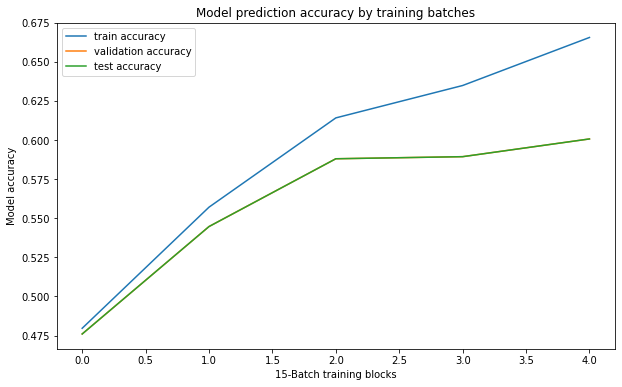

========================= Starting epoch 2 =========================

starting batch 0/67, Loss=0.6109 on:  train_loader
 Accuracy on training: 67.26%
Accuracy on val: 61.00%
Accuracy on test: 61.00% 

starting batch 15/67, Loss=0.6219 on:  train_loader
 Accuracy on training: 69.06%
Accuracy on val: 61.20%
Accuracy on test: 61.20% 

starting batch 30/67, Loss=0.6155 on:  train_loader
 Accuracy on training: 70.46%
Accuracy on val: 62.00%
Accuracy on test: 62.00% 

starting batch 45/67, Loss=0.6326 on:  train_loader
 Accuracy on training: 72.09%
Accuracy on val: 62.33%
Accuracy on test: 62.33% 

starting batch 60/67, Loss=0.6470 on:  train_loader
 Accuracy on training: 72.72%
Accuracy on val: 62.27%
Accuracy on test: 62.27% 
Accuracy:   0.626
F1_score:   0.4829493087557604
Precision:  0.5446985446985447
Recall:     0.4337748344370861


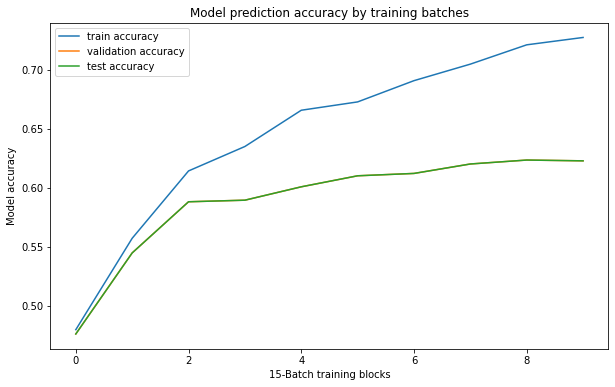

========================= Starting epoch 3 =========================

starting batch 0/67, Loss=0.5150 on:  train_loader
 Accuracy on training: 74.00%
Accuracy on val: 62.53%
Accuracy on test: 62.53% 

starting batch 15/67, Loss=0.5465 on:  train_loader
 Accuracy on training: 74.26%
Accuracy on val: 62.47%
Accuracy on test: 62.47% 

starting batch 30/67, Loss=0.5539 on:  train_loader
 Accuracy on training: 75.28%
Accuracy on val: 62.00%
Accuracy on test: 62.00% 

starting batch 45/67, Loss=0.5159 on:  train_loader
 Accuracy on training: 76.06%
Accuracy on val: 62.13%
Accuracy on test: 62.13% 

starting batch 60/67, Loss=0.5649 on:  train_loader
 Accuracy on training: 76.86%
Accuracy on val: 62.53%
Accuracy on test: 62.53% 
Accuracy:   0.626
F1_score:   0.4857928505957837
Precision:  0.5441478439425051
Recall:     0.43874172185430466


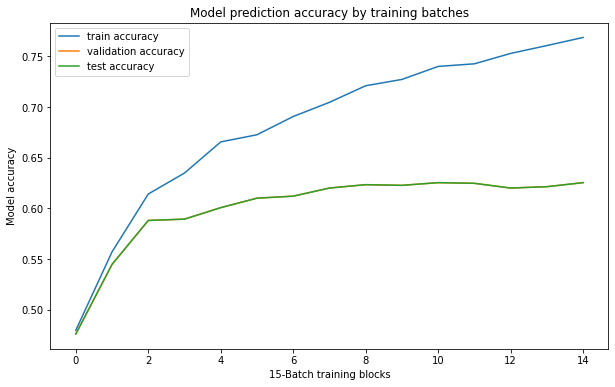

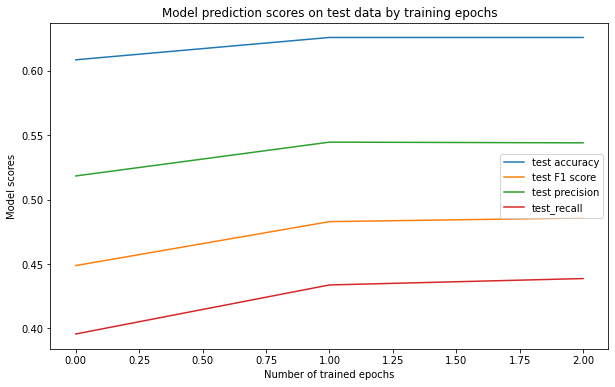

========================= Starting epoch 4 =========================

starting batch 0/67, Loss=0.4781 on:  train_loader
 Accuracy on training: 77.26%
Accuracy on val: 62.27%
Accuracy on test: 62.27% 

starting batch 15/67, Loss=0.5034 on:  train_loader


Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

KeyboardInterrupt: ignored

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nn_model = nn_model.to(device)

train_cnn(nn_model.double(), train_loader, val_loader, val_loader, device, num_epochs=10, lr=1e-5)

In [ ]:
type(torch.randn(3, 10, 10)[0][1, 1].item())

float